In [1]:
import os
import random
import matplotlib.pylab as plt
from glob import glob
import numpy as np

# READ IMAGES AND MASKS

In [2]:
PATH = os.path.abspath('data')

SOURCE_IMAGES = os.path.join(PATH, "images/resized")

images = glob(os.path.join(SOURCE_IMAGES, "*.jpg"))

SOURCE_LABELS = os.path.join(PATH, "labels/resized")

labels = glob(os.path.join(SOURCE_LABELS, "*.png"))

In [3]:
SOURCE_IMAGES

'C:\\Users\\Владислав\\Desktop\\copterutils\\seg\\data\\images/resized'

In [4]:
images.sort()
labels.sort()

In [5]:
print(np.size(images))
print(np.size(labels))

80
80


In [6]:
x = [] # images
y = [] # labels

for img in images:
    full_size_image = plt.imread(img)
    x.append(full_size_image)

for lbl in labels:
    full_size_label = plt.imread(lbl,0)
    y.append(full_size_label)

In [7]:
x = np.asarray(x)
y = np.asarray(y)

In [18]:
print(y.min())
print(y.max())

0
8


In [9]:
print(x.shape)
print(y.shape)

(80, 512, 640, 3)
(80, 512, 640)


### Class weighting

In [10]:
n = np.bincount(y.reshape(y.shape[0]*y.shape[1]*y.shape[2]))

In [11]:
print(str(n/n.sum()*100) + " %")

[  2.13621902   7.65075684  11.0121994    8.47763443  55.69092941
   2.43202972   8.66975021   3.0411911    0.88928986] %


In [12]:
cs = ['background','asphalt', 'building', 'forest', 'grass', 'ground', 'roadAsphalt', 'roadGround', 'water']

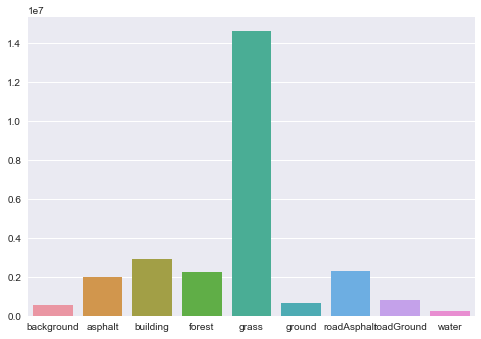

In [13]:
import seaborn as sns

sns.barplot(x=cs, y=n)

In [14]:
cw = np.median(n)/n

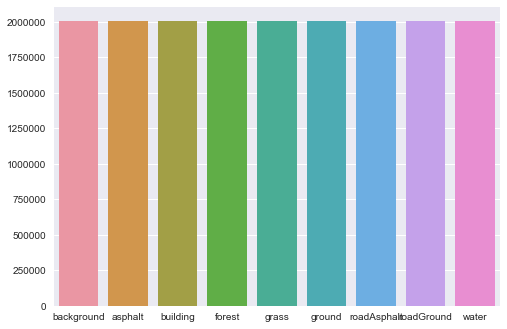

In [15]:
sns.barplot(x=cs, y=n*cw)

In [16]:
class_weights = dict(enumerate(cw))
class_weights

{0: 3.581447757755845,
 1: 1.0,
 2: 0.69475284243839686,
 3: 0.90246364114561051,
 4: 0.13737886791620518,
 5: 3.1458319608747347,
 6: 0.88246565903543894,
 7: 2.5157106481191125,
 8: 8.6032206312574537}

# Convert one mask to N masks

In [19]:
n_images, h, w = y.shape
y = y.reshape([n_images, h*w])
n_classes = len(cs)
temp = np.zeros(np.append(y.shape,n_classes),dtype='int')

In [21]:
for i in range (n_images):
    for j in range(h*w):
            temp[i,j,(y[i,j])] = 1
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


In [22]:
y = temp.reshape([n_images,h,w,n_classes])
del(temp)

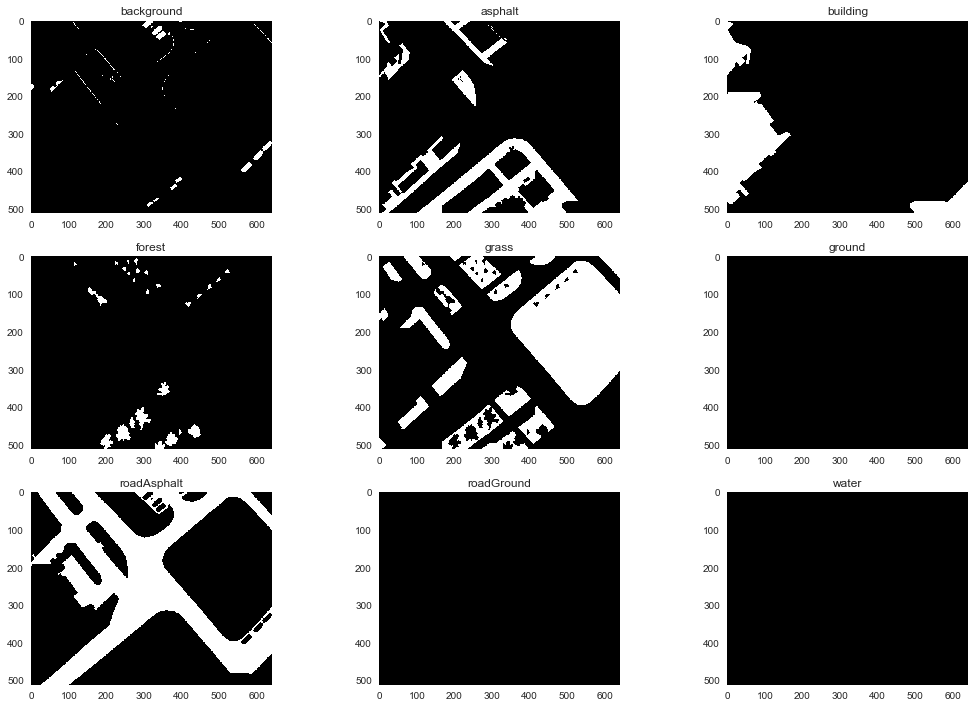

In [23]:
nrows, ncols = 3,3
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(15,10)
cl = 0
im = 59
for i in range(nrows):
    for j in range(ncols):
        axes[i,j].imshow(y[im,:,:,cl], cmap='gray')
        axes[i,j].set_title(cs[cl])
        axes[i,j].grid(None)
        cl += 1
     
fig.tight_layout()

In [24]:
y.dtype

dtype('int32')

In [25]:
print(x.shape)
print(y.shape)

(80, 512, 640, 3)
(80, 512, 640, 9)


# Prepare for training

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=1)

In [28]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60, 512, 640, 3)
(60, 512, 640, 9)
(20, 512, 640, 3)
(20, 512, 640, 9)


In [29]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, optimizers
from keras import backend as K

Using TensorFlow backend.


In [30]:
import tensorflow as tf

In [31]:
K.image_data_format()

'channels_last'

In [32]:
img_width, img_height = w, h
nb_train_samples = len(x_train)
nb_test_samples = len(x_test)
epochs = 1
batch_size = 2

In [33]:
train_datagen = ImageDataGenerator(rescale=1. / 255, horizontal_flip=True, rotation_range=30)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [34]:
train_generator = train_datagen.flow(np.array(x_train), y_train, batch_size=batch_size)
test_generator = test_datagen.flow(np.array(x_test), y_test, batch_size=batch_size)

# Define model

# U-Net

In [35]:
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(pretrained_weights = None, input_size = (256,320,3), n_classes = 9):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
#     merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
#     merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
#     merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
#     merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv10 = Conv2D(n_classes, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Reshape((input_size[0]*input_size[1],n_classes))(conv10)
    conv10 = Activation('softmax')(conv10)
    
    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = 'adadelta', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
#     model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [59]:
model = unet(input_size = (img_height,img_width,3), n_classes=9)

In [60]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 512, 640, 3)   0                                            
____________________________________________________________________________________________________
conv2d_24 (Conv2D)               (None, 512, 640, 64)  1792        input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_25 (Conv2D)               (None, 512, 640, 64)  36928       conv2d_24[0][0]                  
____________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)   (None, 256, 320, 64)  0           conv2d_25[0][0]                  
___________________________________________________________________________________________

In [61]:
y_train_flat = y_train.reshape(y_train.shape[0],y_train.shape[1]*y_train.shape[2],y_train.shape[3])
y_train_flat.shape

(60, 327680, 9)

In [62]:
y_test_flat = y_test.reshape(y_test.shape[0],y_test.shape[1]*y_test.shape[2],y_test.shape[3])
y_test_flat.shape

(20, 327680, 9)

In [63]:
def get_tf_session():
    gpu_options = tf.GPUOptions(allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(get_tf_session())

In [64]:
class_weighting = np.fromiter(class_weights.values(), dtype=float)

In [65]:
history = model.fit(x_train, y_train_flat, batch_size=1, epochs=5, verbose=1, class_weight=class_weighting)

Epoch 1/5
60/60 [==============================] - 160s - loss: 15.3775 - acc: 0.0459   
Epoch 2/5
60/60 [==============================] - 159s - loss: 15.3408 - acc: 0.0482   
Epoch 3/5
60/60 [==============================] - 159s - loss: 12.2611 - acc: 0.2393   
Epoch 4/5
60/60 [==============================] - 160s - loss: 6.6538 - acc: 0.5872   
Epoch 5/5
60/60 [==============================] - 159s - loss: 6.4032 - acc: 0.6027   


In [67]:
model.save_weights('model_weight_ep5.hdf5')

In [74]:
score = model.evaluate(x_test, y_test_flat, batch_size = 1, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

20/20 [==============================] - 13s    
Test score: 9.35732319355
Test accuracy: 0.419451296888


### Test pretrained model

In [75]:
model2 = unet(input_size = (img_height,img_width,3), n_classes=9)

In [76]:
model2.load_weights('model_weight_ep5.hdf5')

In [77]:
score = model2.evaluate(x_test, y_test_flat, batch_size = 1, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

20/20 [==============================] - 14s    
Test score: 9.35732319355
Test accuracy: 0.419451296888


# Training

In [148]:
history = model.fit_generator(
    generator=train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    sample_weights = class_weights,
    verbose = 1
)

TypeError: fit_generator() got an unexpected keyword argument 'sample_weights'

In [149]:
a = model.fit(x=x_train, y=y_train, batch_size=1, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=class_weights2, initial_epoch=0, steps_per_epoch=None, validation_steps=None)

ValueError: Found a sample_weight array with shape (512, 640, 8). In order to use timestep-wise sample weights, you should specify sample_weight_mode="temporal" in compile(). If you just mean to use sample-wise weights, make sure your sample_weight array is 1D.

# Load/Save model

In [ ]:
from keras.models import load_model
import pickle

In [ ]:
model.save('model2.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
model = load_model('model1.h5')

In [ ]:
with open('history2', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
history.history

# Evaluate

In [ ]:
iz = model.evaluate_generator(test_generator, max_queue_size=10, workers=1, use_multiprocessing=False, steps=None)

In [ ]:
a = model.evaluate(x_test, y_test, batch_size = batch_size, verbose=1, sample_weight=None, steps=None)

In [ ]:
a

In [ ]:
model.metrics_names

In [ ]:
print(y_test.shape)
print(a.shape)

In [ ]:
def pixel_accuracy(eval_segm, gt_segm):
    '''
    sum_i(n_ii) / sum_i(t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    sum_n_ii = 0
    sum_t_i  = 0

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)
 
    if (sum_t_i == 0):
        pixel_accuracy_ = 0
    else:
        pixel_accuracy_ = sum_n_ii / sum_t_i

    return pixel_accuracy_

def mean_accuracy(eval_segm, gt_segm):
    '''
    (1/n_cl) sum_i(n_ii/t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    accuracy = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
 
        if (t_i != 0):
            accuracy[i] = n_ii / t_i

    mean_accuracy_ = np.mean(accuracy)
    return mean_accuracy_

def mean_IU(eval_segm, gt_segm):
    '''
    (1/n_cl) * sum_i(n_ii / (t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl   = union_classes(eval_segm, gt_segm)
    _, n_cl_gt = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    IU = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        IU[i] = n_ii / (t_i + n_ij - n_ii)
 
    mean_IU_ = np.sum(IU) / n_cl_gt
    return mean_IU_

def frequency_weighted_IU(eval_segm, gt_segm):
    '''
    sum_k(t_k)^(-1) * sum_i((t_i*n_ii)/(t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = union_classes(eval_segm, gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    frequency_weighted_IU_ = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        frequency_weighted_IU_[i] = (t_i * n_ii) / (t_i + n_ij - n_ii)
 
    sum_k_t_k = get_pixel_area(eval_segm)
    
    frequency_weighted_IU_ = np.sum(frequency_weighted_IU_) / sum_k_t_k
    return frequency_weighted_IU_

'''
Auxiliary functions used during evaluation.
'''
def get_pixel_area(segm):
    return segm.shape[0] * segm.shape[1]

def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)

    return cl, n_cl

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)

    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise

    return height, width

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")

'''
Exceptions
'''
class EvalSegErr(Exception):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)

In [ ]:
kek = pixel_accuracy(a[0,:,:,0], y_test[0,:,:,0])

In [ ]:
a[0,:,:,0].shape

In [ ]:
kek

In [ ]:
y_test[0,:,:,0]